# Analysis of live reported understanding ratings
from the Bach visualisation online study

Participants watched a relatively simple or complex visualisation of a concert performance of a Bach Fugue and reported changes in their level of understanding (?) from 1 (low) to 5 (high) while the music played. 

This notebook importes the changes in ratings in the edited response data file, interpolates for analysis, and reports the distributions of reported understanding over time for 4 conditions:

- simple1:  the simple visualisation ratings when seen first
- complex1: the complex visualisation ratings when send first
- simple2:  the simple visualisation ratings when seen second
- complex2: the complex visualisation ratings when send second


Simple:
https://youtu.be/00w8O77E1SA
Complex:
https://youtu.be/zdn9e9R4sAs

11:44 and 11:40

In [82]:
import sys
import os
import time
import datetime as dt
import math
import numpy as np 
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
from scipy.signal import butter,filtfilt
from scipy import interpolate
from scipy.interpolate import interp1d


/Users/finn/.pyenv/versions/3.9.0/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
A_df = pd.read_csv('./data_input/edited.csv')
print(len(A_df))

53


In [7]:
A_df


,StartDate,EndDate,DurationinSeconds,RecordedDate,Q3,Q4,Q5,Q6,Q7,Q8,...,Q27,Q49,Q52,Q53,Q54,Q58,complex1,simple1,complex2,simple2
0,2022-07-19 03:34:32,2022-07-19 03:43:36,544,2022-07-19 03:43:36,4,4,4,4,3,3,...,2,3.0,30.0,2,6,NaN,NaN,13.87 5 M;37.19 3 M;85.49 4 M;668.32 3 51;,NaN,215.18 4 M;653.02 3 51;
1,2022-07-19 03:31:36,2022-07-19 03:54:43,1387,2022-07-19 03:54:44,4,3,3,1,4,2,...,1,3.0,23.0,1,4,NaN,15.42 5 M;29.33 3 M;65.06 4 M;69.56 1 M;100.86...,NaN,7.5 5 M;86.37 3 M;233.37 2 98;233.37 3 99;,NaN
2,2022-07-19 03:49:08,2022-07-19 03:57:59,530,2022-07-19 03:57:59,5,4,5,5,1,3,...,1,3.0,34.0,2,5,NaN,NaN,45.61 5 M;58.28 3 51;58.28 4 52;,96.81 3 M;128.85 3 51;128.85 4 52;,NaN
3,2022-07-19 14:27:58,2022-07-19 15:44:33,4594,2022-07-19 15:44:33,5,5,5,5,1,5,...,1,3.0,24.0,3,4,it was really hard to pay attention to the sec...,18.03 5 M;25.39 4 M;30.88 5 M;85.98 4 M;140.54...,NaN,NaN,8.44 4 M;22.46 2 M;24.76 3 M;25.83 4 M;56.89 5...
4,2022-07-19 15:01:56,2022-07-19 22:49:06,28029,2022-07-19 22:49:06,4,5,3,4,2,4,...,1,3.0,39.0,2,3,NaN,392.32 4 M;700.82 3 51;,NaN,NaN,628.48 4 M;631.03 3 M;703.97 3 51;
5,2022-07-20 02:16:16,2022-07-20 02:46:12,1796,2022-07-20 02:46:13,4,5,4,4,1,5,...,2,3.0,51.0,2,4,NaN,15.32 5 M;33.15 4 M;90.03 5 M;101.19 4 M;367.7...,NaN,45.02 4 M;700.82 5 53;700.82 1 49;,NaN
6,2022-07-20 02:25:03,2022-07-20 02:56:32,1889,2022-07-20 02:56:33,3,4,3,3,4,2,...,2,3.0,25.0,1,3,NaN,12.01 5 M;27.92 3 M;38.85 5 M;72.75 4 M;123.74...,NaN,NaN,13.56 5 M;37.23 3 M;39.7 4 M;223.61 5 M;230.76...
7,2022-07-20 08:36:14,2022-07-20 09:35:27,3552,2022-07-20 09:35:28,5,5,5,5,3,4,...,1,3.0,26.0,1,7,I think this tool may be very nice for pedagog...,NaN,18.68 5 M;27.53 5 M;36.63 5 M;38.56 5 M;42.77 ...,11.04 5 M;24.99 5 M;38.32 5 M;53.66 5 M;74.92 ...,NaN
8,2022-07-23 02:09:31,2022-07-23 02:37:55,1703,2022-07-23 02:37:56,5,5,5,5,1,4,...,3,3.0,45.0,2,6,NaN,NaN,26.38 5 M;81.43 5 M;81.97 5 M;173.04 1 M;182.5...,14.19 5 M;36.76 5 M;110.09 5 M;282.75 5 M;365....,NaN
9,2022-07-23 09:09:50,2022-07-23 09:47:32,2261,2022-07-23 09:47:32,4,4,4,2,4,2,...,2,3.0,44.0,2,4,"Found the two versions quite similar, the visu...",17.74 5 M;56.7 4 M;73.41 3 M;90.65 4 M;136.92 ...,NaN,18.31 5 M;57.31 4 M;97.36 3 M;166.15 4 M;188.9...,NaN


In [8]:
# Example of data format
A_df.loc[0,['complex1','simple1', 'complex2', 'simple2']]

complex1                                           NaN
simple1     13.87 5 M;37.19 3 M;85.49 4 M;668.32 3 51;
complex2                                           NaN
simple2                        215.18 4 M;653.02 3 51;
Name: 0, dtype: object

In [9]:
def button_parse(press_string):
    if(press_string != press_string):
        print(press_string)
        return         
    else:
        presses = press_string.split(';')
        Times = [0]
        Values = [0]
        Types = ['P']
        for p in presses:
            vals = p.split(' ')
            if len(vals) == 3:
                Times.append(float(vals[0]))
                Values.append(int(vals[1]))
                Types.append(vals[2])
        
        X = pd.DataFrame(columns = ['Time','Value','Type'])
        X['Time'] = Times
        X['Value'] = Values
        X['Type'] = Types
        return X
    
def make_step(press_string, sampletime):
    if(press_string != press_string):
        return ['no','buttons']        
    else:
        X = button_parse(press_string)
        f = interpolate.interp1d(X['Time'], X['Value'],kind='previous',fill_value="extrapolate") 
        return f(sampletime)   


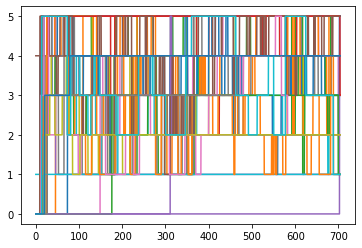

In [5]:
sampletime = np.arange(0.1,704, 0.1)
S = pd.DataFrame(index = sampletime)
for i in A_df.index:
    B = make_step(A_df.loc[i,'simple1'], sampletime)
    if len(B)>2:
        S[i] = B
        
S.plot(legend=False)
plt.show()

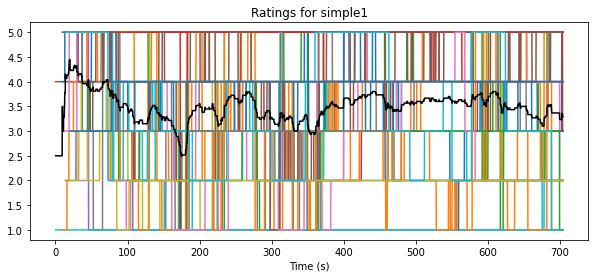

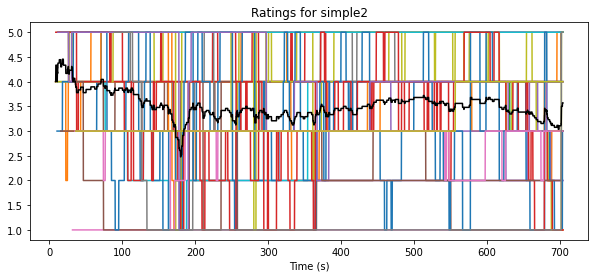

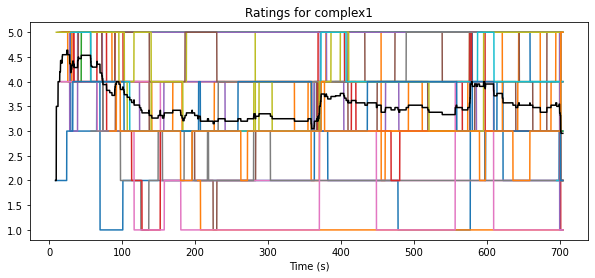

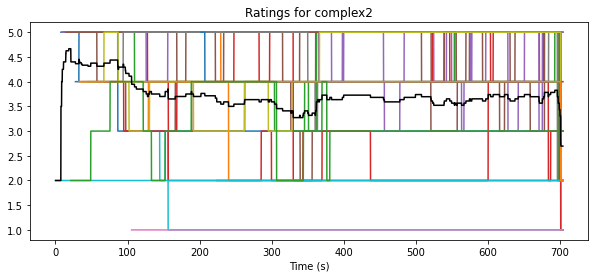

In [6]:
sampletime = np.arange(0.1,704, 0.1)
S_Means = pd.DataFrame(index = sampletime)
ContR = {}
for pres in ['simple1', 'simple2','complex1', 'complex2']:
    S = pd.DataFrame(index = sampletime)
    for i in A_df.index:
        B = make_step(A_df.loc[i,pres], sampletime)
        if len(B)>2:
            S[i] = B
    S=S.mask(S<1,np.nan)
    
    # save the results
    S_Means[pres] = S.mean(axis=1)
    S.mean(axis=1).to_csv('./data_output/' +pres + '_mean_10z.csv',index=True) # G.to_csv('./data_output/button_values_'+pres +'_10Hz.csv',index=True)
    S.to_csv('./data_output/' +pres + '_10z.csv',index=True) # G.to_csv('./data_output/button_values_'+pres +'_10Hz.csv',index=True)
    ContR[pres] = S
    
    # plot 
    S.plot(legend=False,figsize=[10,4])
    S.mean(axis=1).plot(color='k')
    plt.title('Ratings for ' + pres)
    plt.xlabel('Time (s)')
    plt.savefig('./plots/' + pres + '_step_and_mean_10z.png',dpi = 300)
    plt.show()


In [11]:
S.sum()

1     22473.0
2     23964.0
5     26263.0
7     31958.0
8     33460.0
9     27126.0
12    10110.0
13     9606.0
16    34470.0
17     6722.0
18    33767.0
19    16795.0
20    30139.0
23    17904.0
25    33296.0
27    33470.0
28     5984.0
30    29177.0
33    28897.0
35    14078.0
43    20111.0
45    26794.0
50    21311.0
dtype: float64

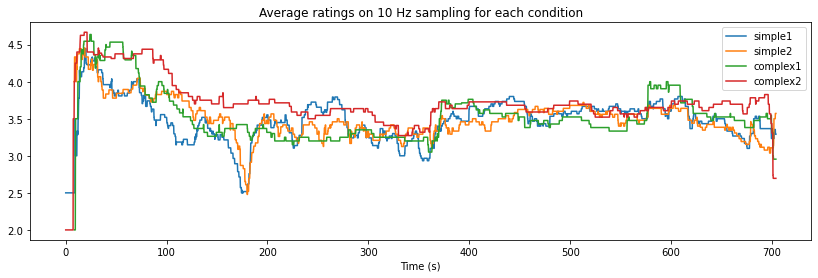

In [7]:
S_Means.plot(figsize=[14,4])
plt.title('Average ratings on 10 Hz sampling for each condition')
plt.xlabel('Time (s)')
plt.savefig('./plots/Means_10z.png',dpi = 300)
plt.show()

## Means of ratings depending on previous stimulus

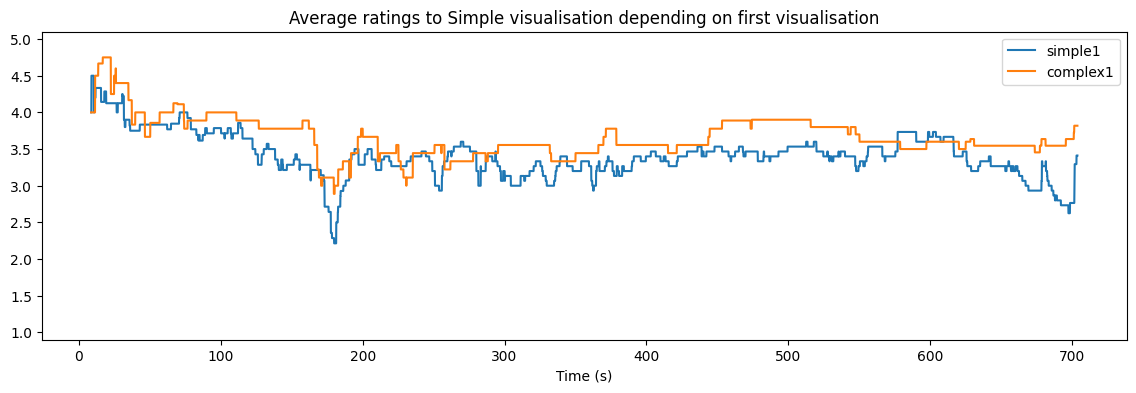

In [26]:
# conditions of prev
ContR['simple2'][list(set(ContR['simple1'].columns).intersection(set(ContR['simple2'].columns)))].mean(axis=1).plot(figsize=[14,4],label = 'simple1',legend=True)
ContR['simple2'][list(set(ContR['complex1'].columns).intersection(set(ContR['simple2'].columns)))].mean(axis=1).plot(label = 'complex1',legend=True)

plt.title('Average ratings to Simple visualisation depending on first visualisation')
plt.xlabel('Time (s)')
plt.ylim([0.9,5.1])
plt.savefig('./plots/Simple2_cond_Means_10z.png',dpi = 300)
plt.show()


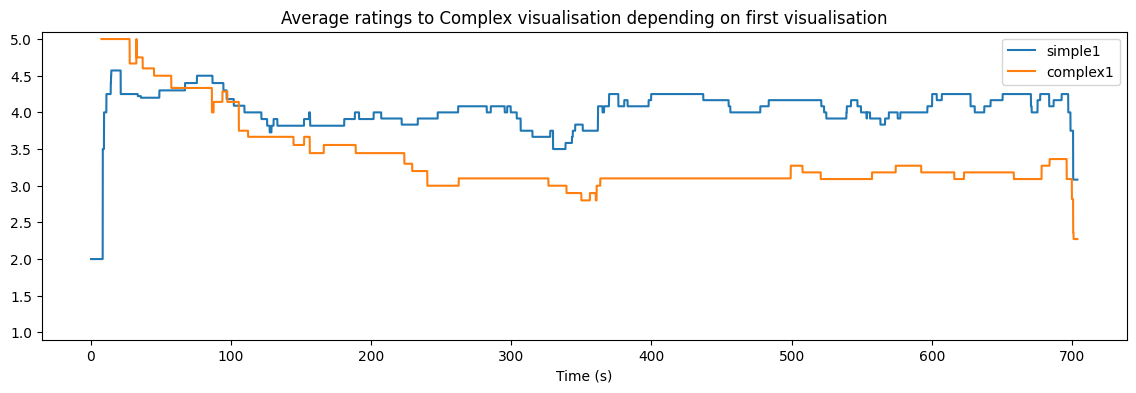

In [25]:
# conditions of prev
ContR['complex2'][list(set(ContR['simple1'].columns).intersection(set(ContR['complex2'].columns)))].mean(axis=1).plot(figsize=[14,4],label = 'simple1',legend=True)
ContR['complex2'][list(set(ContR['complex1'].columns).intersection(set(ContR['complex2'].columns)))].mean(axis=1).plot(label = 'complex1',legend=True)

plt.title('Average ratings to Complex visualisation depending on first visualisation')
plt.xlabel('Time (s)')
plt.ylim([0.9,5.1])
plt.savefig('./plots/Complex2_cond_Means_10z.png',dpi = 300)
plt.show()


# Distributions of ratings over time
Area plot that give distribution of reported values, showing when participants changed ratings

In [112]:
#plt.style.use('ggplot')
plt.style.use('default')
pal = ["#DDDDDD","#FFC300","#FF5733","#C70039","#900C3F","#581845"] # red


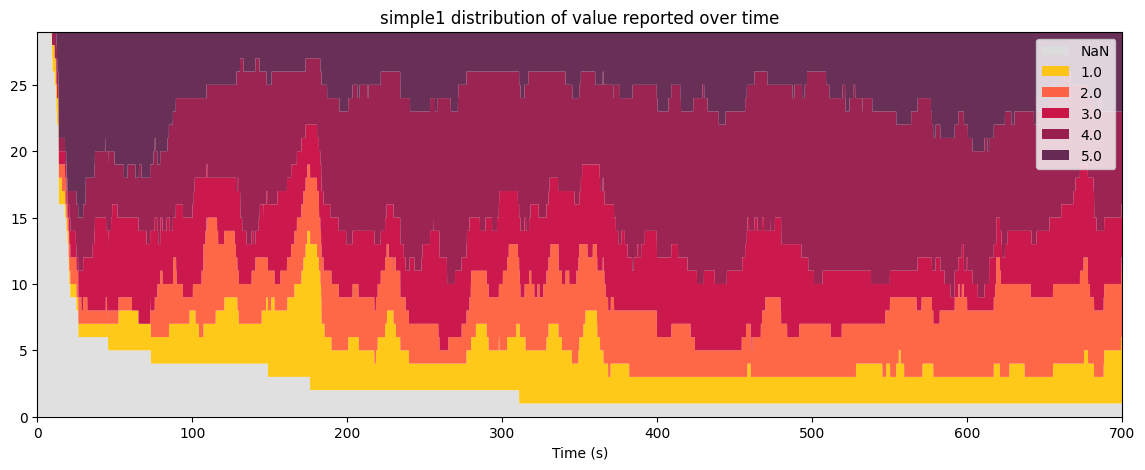

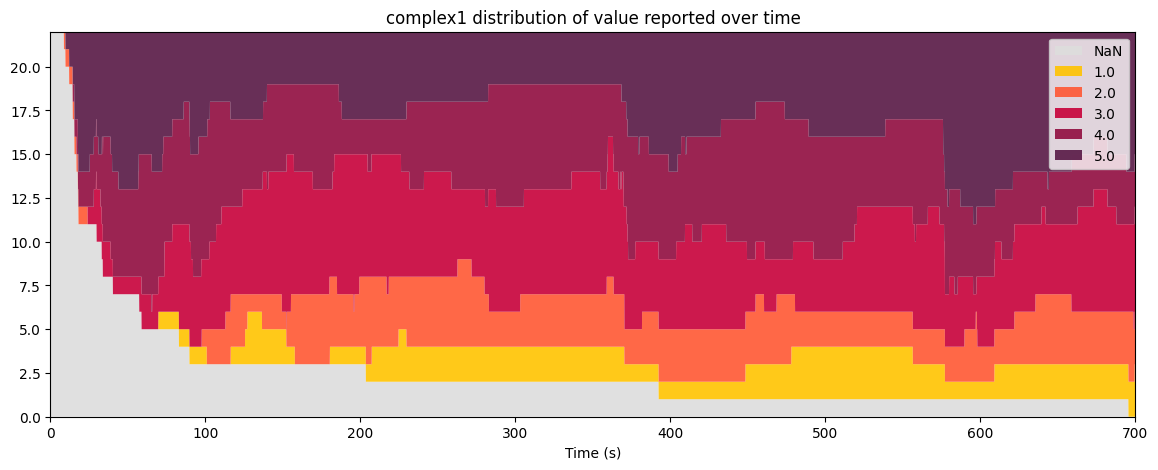

In [32]:
# count proportions of each value at each timestep 
# [NaN,1.0,2.0,3.0,4.0,5.0]
for pres in ['simple1','complex1']:
    B = ContR[pres]
    G = pd.DataFrame(columns = [5.0,4.0,3.0,2.0,1.0],index = B.index)
    for i,row in B.iterrows(): # this is really slow. Maybe could be performed with mask instead 
        a = row.value_counts()
        G.loc[i,a.index] = a.values
    G['NaN']=len(B.columns)-G.sum(axis=1)
    G.fillna(0,inplace=True)
    G.to_csv('./data_output/button_values_'+pres +'_10Hz.csv',index=True)


    fig, ax = plt.subplots(figsize=[14,5])
    plt.stackplot(G.index,G[['NaN',1.0,2.0,3.0,4.0,5.0]].transpose().values,labels=['NaN',1.0,2.0,3.0,4.0,5.0], colors=pal, alpha=0.9)
    plt.legend()
    plt.title(pres + ' distribution of value reported over time')
    plt.xlabel('Time (s)')
    plt.xlim([0,700])
    plt.ylim([0,G.max().max()])
    plt.savefig('./plots/' + pres + '_Area_dist_10z.png',dpi = 300)
    plt.show()

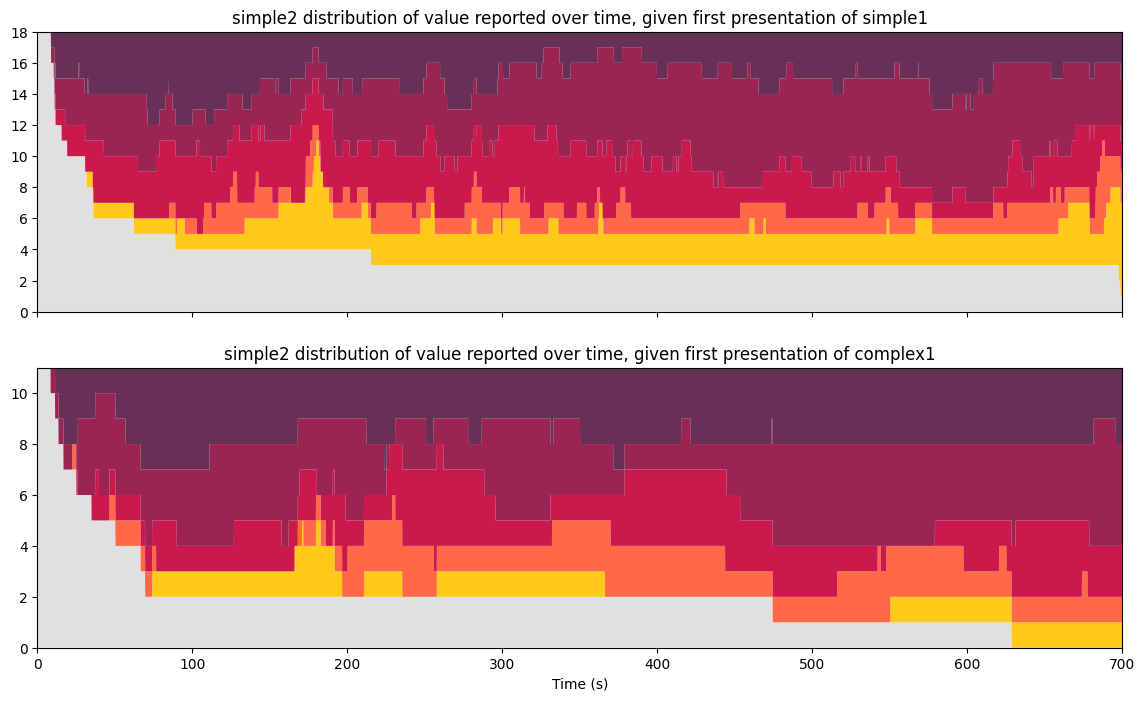

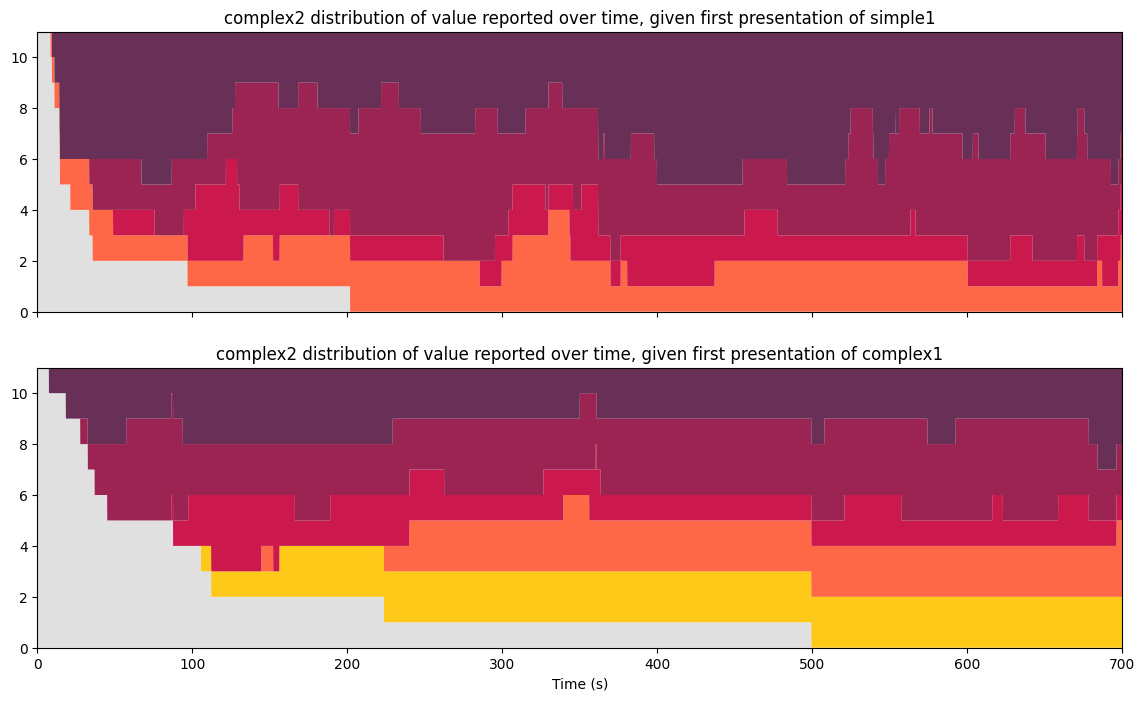

In [31]:
# count proportions of each value at each timestep 
# [NaN,1.0,2.0,3.0,4.0,5.0]
for pres in ['simple2','complex2']:
    fig, (ax1, ax2) = plt.subplots(2, 1,sharex=True,figsize=[14,8])
    
    B = ContR[pres][list(set(ContR['simple1'].columns).intersection(set(ContR[pres].columns)))]
    G = pd.DataFrame(columns = [5.0,4.0,3.0,2.0,1.0],index = B.index)
    for i,row in B.iterrows(): # this is really slow. Maybe could be performed with mask instead 
        a = row.value_counts()
        G.loc[i,a.index] = a.values
    G['NaN']=len(B.columns)-G.sum(axis=1)
    G.fillna(0,inplace=True)
    G.to_csv('./data_output/button_values_'+pres +'_simple1_10Hz.csv',index=True)
    
    ax1.set_title(pres + ' distribution of value reported over time, given first presentation of simple1')
    ax1.stackplot(G.index,G[['NaN',1.0,2.0,3.0,4.0,5.0]].transpose().values,labels=['NaN',1.0,2.0,3.0,4.0,5.0], colors=pal, alpha=0.9)
    ax1.set_ylim([0,G.max().max()])
    
    B = ContR[pres][list(set(ContR['complex1'].columns).intersection(set(ContR[pres].columns)))]
    G = pd.DataFrame(columns = [5.0,4.0,3.0,2.0,1.0],index = B.index)
    for i,row in B.iterrows(): # this is really slow. Maybe could be performed with mask instead 
        a = row.value_counts()
        G.loc[i,a.index] = a.values
    G['NaN']=len(B.columns)-G.sum(axis=1)
    G.fillna(0,inplace=True)
    G.to_csv('./data_output/button_values_'+pres +'_complex1_10Hz.csv',index=True)
    ax2.set_title(pres + ' distribution of value reported over time, given first presentation of complex1')
    ax2.stackplot(G.index,G[['NaN',1.0,2.0,3.0,4.0,5.0]].transpose().values,labels=['NaN',1.0,2.0,3.0,4.0,5.0], colors=pal, alpha=0.9)
    ax2.set_title(pres + ' distribution of value reported over time, given first presentation of complex1')
    ax2.set_xlabel('Time (s)')
    ax2.set_xlim([0,700])
    ax2.set_ylim([0,G.max().max()])
    
    plt.savefig('./plots/' + pres + '_split_Area_dist_10z.png',dpi = 300)
    plt.show()

# ordered learning plots, first second viewings.

per pair of stimulus conditions, plot participant-wise understanding plots, ordered by total understanding on first viewing

https://matplotlib.org/stable/tutorials/colors/colormaps.html

[-0.0024151157834919734, 0.7937759647705503]
[-17.0, 5587.3890160199035]


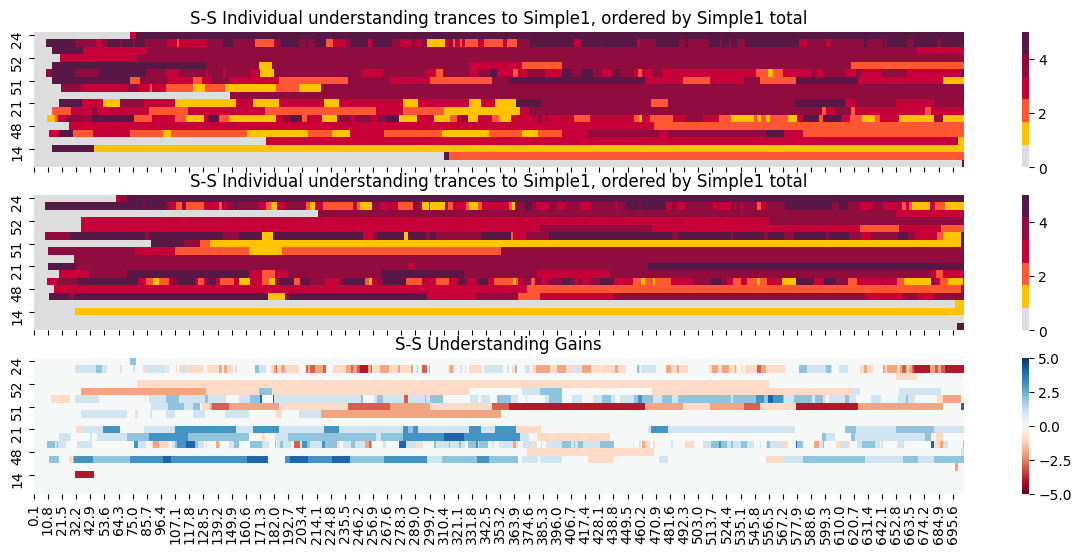

In [118]:
v1 = 'simple1'
v2 = 'simple2'
A = ContR[v1][list(set(ContR[v1].columns).intersection(set(ContR[v2].columns)))]
Und_Ord = A.sum().sort_values(ascending=False).index
B = ContR[v2][list(set(ContR[v2].columns).intersection(set(ContR[v1].columns)))]

fig, (ax1, ax2,ax3) = plt.subplots(3, 1,sharex=True,figsize=[15,6])
df_A = A[Und_Ord].copy()
df_A.fillna(0,inplace=True)
chart = sns.heatmap(data=df_A.transpose(), ax=ax1,vmin=0, vmax=5,cmap=pal)
ax1.set_xticklabels(np.round(df_A.iloc[ax1.get_xticks()].index,2))
ax1.set_title('S-S Individual understanding trances to Simple1, ordered by Simple1 total')

df_A = B[Und_Ord].copy()
df_A.fillna(0,inplace=True)
chart = sns.heatmap(data=df_A.transpose(), ax=ax2,vmin=0, vmax=5,cmap=pal)
ax2.set_xticklabels(np.round(df_A.iloc[ax2.get_xticks()].index,2))
ax2.set_title('S-S Individual understanding trances to Simple1, ordered by Simple1 total')

df_A = B[Und_Ord].copy() - A[Und_Ord].copy()
df_A.fillna(0,inplace=True)
chart = sns.heatmap(data=df_A.transpose(), ax=ax3,vmin=-5, vmax=5,cmap='RdBu')
ax3.set_xticklabels(np.round(df_A.iloc[ax2.get_xticks()].index,2))
ax3.set_title('S-S Understanding Gains')
print([df_A.mean().median(),df_A.mean().std()])
print([df_A.sum().median(),df_A.sum().std()])

plt.savefig('./plots/' + v1 + '_' + v2 + '_indiv_gains.png',dpi = 300)
plt.show()

[0.26246625941184826, 0.511466304211799]
[1847.5, 3600.2113153468526]


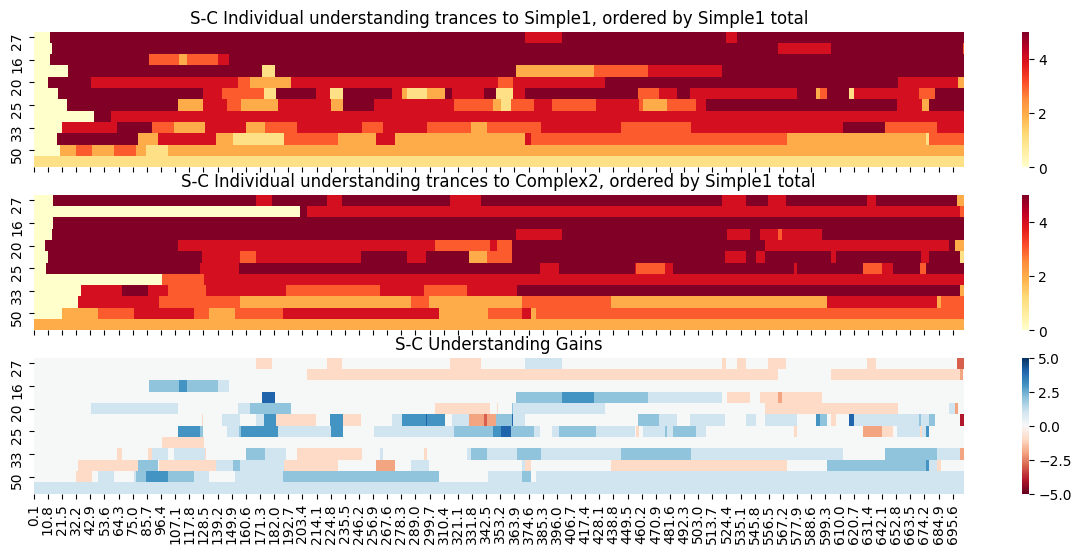

In [119]:
v1 = 'simple1'
v2 = 'complex2'
A = ContR[v1][list(set(ContR[v1].columns).intersection(set(ContR[v2].columns)))]
Und_Ord = A.sum().sort_values(ascending=False).index
B = ContR[v2][list(set(ContR[v2].columns).intersection(set(ContR[v1].columns)))]

fig, (ax1, ax2,ax3) = plt.subplots(3, 1,sharex=True,figsize=[15,6])
df_A = A[Und_Ord].copy()
df_A.fillna(0,inplace=True)
chart = sns.heatmap(data=df_A.transpose(), ax=ax1,vmin=0, vmax=5,cmap='YlOrRd')
ax1.set_xticklabels(np.round(df_A.iloc[ax1.get_xticks()].index,2))
ax1.set_title('S-C Individual understanding trances to Simple1, ordered by Simple1 total')

df_A = B[Und_Ord].copy()
df_A.fillna(0,inplace=True)
chart = sns.heatmap(data=df_A.transpose(), ax=ax2,vmin=0, vmax=5,cmap='YlOrRd')
ax2.set_xticklabels(np.round(df_A.iloc[ax2.get_xticks()].index,2))
ax2.set_title('S-C Individual understanding trances to Complex2, ordered by Simple1 total')

df_A = B[Und_Ord].copy() - A[Und_Ord].copy()
df_A.fillna(0,inplace=True)
chart = sns.heatmap(data=df_A.transpose(), ax=ax3,vmin=-5, vmax=5,cmap='RdBu')
ax3.set_xticklabels(np.round(df_A.iloc[ax2.get_xticks()].index,2))
ax3.set_title('S-C Understanding Gains')
print([df_A.mean().median(),df_A.mean().std()])
print([df_A.sum().median(),df_A.sum().std()])

plt.savefig('./plots/' + v1 + '_' + v2 + '_indiv_gains.png',dpi = 300)
plt.show()

[0.10342378178718568, 0.6303239239858899]
[728.0, 4436.850100936679]


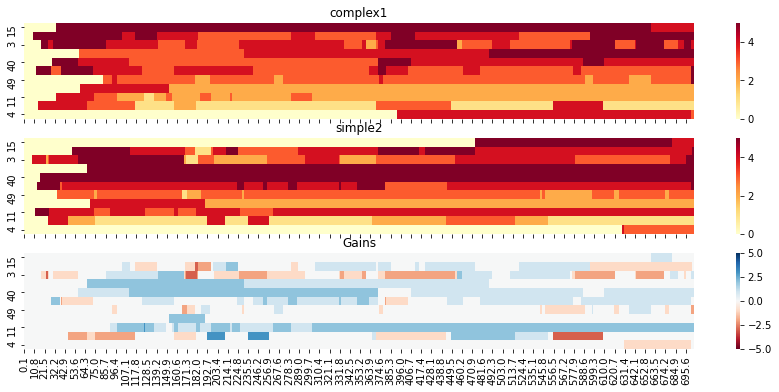

In [109]:
v1 = 'complex1'
v2 = 'simple2'
A = ContR[v1][list(set(ContR[v1].columns).intersection(set(ContR[v2].columns)))]
Und_Ord = A.sum().sort_values(ascending=False).index
B = ContR[v2][list(set(ContR[v2].columns).intersection(set(ContR[v1].columns)))]

fig, (ax1, ax2,ax3) = plt.subplots(3, 1,sharex=True,figsize=[15,6])
df_A = A[Und_Ord].copy()
df_A.fillna(0,inplace=True)
chart = sns.heatmap(data=df_A.transpose(), ax=ax1,vmin=0, vmax=5,cmap=pal)
ax1.set_xticklabels(np.round(df_A.iloc[ax1.get_xticks()].index,2))
ax1.set_title('C-S Individual understanding trances to Complex1, ordered by Complex1 total')

df_A = B[Und_Ord].copy()
df_A.fillna(0,inplace=True)
chart = sns.heatmap(data=df_A.transpose(), ax=ax2,vmin=0, vmax=5,cmap=pal)
ax2.set_xticklabels(np.round(df_A.iloc[ax2.get_xticks()].index,2))
ax1.set_title('C-S Individual understanding trances to Simple2, ordered by Complex1 total')

df_A = B[Und_Ord].copy() - A[Und_Ord].copy()
df_A.fillna(0,inplace=True)
chart = sns.heatmap(data=df_A.transpose(), ax=ax3,vmin=-5, vmax=5,cmap='RdBu')
ax3.set_xticklabels(np.round(df_A.iloc[ax2.get_xticks()].index,2))
ax3.set_title('C-S Understanding Gains')
print([df_A.mean().median(),df_A.mean().std()])
print([df_A.sum().median(),df_A.sum().std()])

plt.savefig('./plots/' + v1 + '_' + v2 + '_indiv_gains.png',dpi = 300)
plt.show()

[0.0, 1.138977572700602]
[0.0, 8017.263134239537]


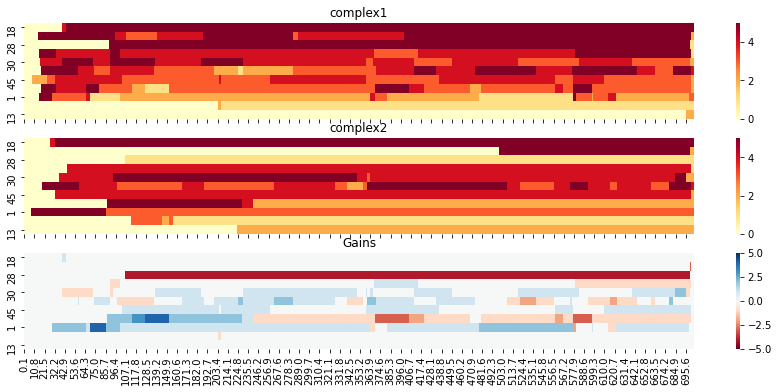

In [110]:
v1 = 'complex1'
v2 = 'complex2'
A = ContR[v1][list(set(ContR[v1].columns).intersection(set(ContR[v2].columns)))]
Und_Ord = A.sum().sort_values(ascending=False).index
B = ContR[v2][list(set(ContR[v2].columns).intersection(set(ContR[v1].columns)))]

fig, (ax1, ax2,ax3) = plt.subplots(3, 1,sharex=True,figsize=[15,6])
df_A = A[Und_Ord].copy()
df_A.fillna(0,inplace=True)
chart = sns.heatmap(data=df_A.transpose(), ax=ax1,vmin=0, vmax=5,cmap='YlOrRd')
ax1.set_xticklabels(np.round(df_A.iloc[ax1.get_xticks()].index,2))
ax1.set_title(v1)

df_A = B[Und_Ord].copy()
df_A.fillna(0,inplace=True)
chart = sns.heatmap(data=df_A.transpose(), ax=ax2,vmin=0, vmax=5,cmap='YlOrRd')
ax2.set_xticklabels(np.round(df_A.iloc[ax2.get_xticks()].index,2))
ax2.set_title(v2)

df_A = B[Und_Ord].copy() - A[Und_Ord].copy()
df_A.fillna(0,inplace=True)
chart = sns.heatmap(data=df_A.transpose(), ax=ax3,vmin=-5, vmax=5,cmap='RdBu')
ax3.set_xticklabels(np.round(df_A.iloc[ax2.get_xticks()].index,2))
ax3.set_title('Gains')
print([df_A.mean().median(),df_A.mean().std()])
print([df_A.sum().median(),df_A.sum().std()])

plt.savefig('./plots/' + v1 + '_' + v2 + '_indiv_gains.png',dpi = 300)
plt.show()

# Testing total understanding differences between vis conditions (with order)


In [ ]:
A = ContR[v1][list(set(ContR[v1].columns).intersection(set(ContR[v2].columns)))]


In [80]:
df_totals = pd.DataFrame(columns = ['First view','First total','Second view','Second total'])
df_totals

,First view,First total,Second view,Second total


In [101]:
df_totals.loc[:,'First total'] = pd.concat([ContR['simple1'].sum(),ContR['complex1'].sum()],axis=0)
df_totals.loc[ContR['simple1'].columns,'First view'] = 'simple'
df_totals.loc[ContR['complex1'].columns,'First view'] = 'complex'
df_totals.loc[:,'Second total'] = pd.concat([ContR['simple2'].sum(),ContR['complex2'].sum()],axis=0)
df_totals.loc[ContR['simple2'].columns,'Second view'] = 'simple'
df_totals.loc[ContR['complex2'].columns,'Second view'] = 'complex'
df_totals['Diff_total'] = df_totals.loc[:,'Second total'] - df_totals.loc[:,'First total']
df_totals

,First view,First total,Second view,Second total,Diff_total
0,simple,26998.0,simple,19043.0,-7955.0
2,simple,26458.0,complex,23964.0,-2494.0
7,simple,28200.0,complex,31958.0,3758.0
8,simple,30342.0,complex,33460.0,3118.0
14,simple,8182.0,simple,6723.0,-1459.0
16,simple,33378.0,complex,34470.0,1092.0
20,simple,29345.0,complex,30139.0,794.0
21,simple,21881.0,simple,30289.0,8408.0
22,simple,23772.0,simple,22222.0,-1550.0
23,simple,19017.0,complex,17904.0,-1113.0


In [83]:
pg.ttest(df_totals.loc[ContR['simple1'].columns,'First total'],df_totals.loc[ContR['complex1'].columns,'First total'])

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.293216,43.442163,two-sided,0.770753,"[-4226.02, 5664.47]",0.082693,0.289,0.059762


In [84]:
pg.ttest(df_totals.loc[ContR['simple2'].columns,'First total'],df_totals.loc[ContR['complex2'].columns,'First total'])

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-1.333094,41.156701,two-sided,0.189833,"[-8265.72, 1691.93]",0.382621,0.579,0.269464


In [102]:
df_totals
df_totals.anova(dv="Diff_total", between=['First view', 'Second view']).round(3)

,Source,SS,DF,MS,F,p-unc,np2
0,First view,2.127575e+07,1.0,2.127575e+07,0.294,0.590,0.006
1,Second view,4.708118e+06,1.0,4.708118e+06,0.065,0.800,0.001
2,First view * Second view,6.692518e+07,1.0,6.692518e+07,0.925,0.341,0.019
3,Residual,3.473877e+09,48.0,7.237244e+07,NaN,NaN,NaN
